# ATS655 - Homework 3 Solutions

In [1]:
%matplotlib inline
# %load_ext autotime

import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import pandas as pd  # library for data analysis for text files (everything but netcdf files)
import seaborn as sns
import csv
import copy as copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

## Problem 1

Make the data and check it is correct.

In [2]:
auto_vec = np.array([0, 0.25, 0.5, 0.92])

Nred = 100000
dataMatrix = np.empty(shape=(len(auto_vec), Nred))

# create red-noise time series iteratively
for ia, a in enumerate(auto_vec):
    b = np.sqrt(1.0 - a**2)
    x = []
    x.append(
        np.random.normal(
            0.0,
            1.0,
            size=1,
        )
    )
    for it in np.arange(0, Nred - 1, 1):
        x.append(a * x[it] + b * np.random.normal(size=1))
    x = np.asarray(x)[:, 0]
    dataMatrix[ia, :] = x

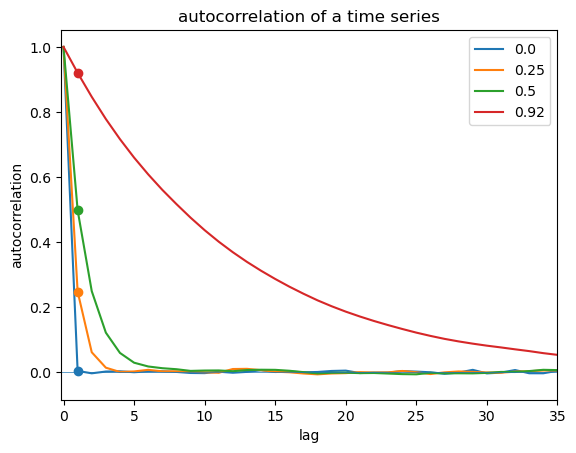

In [3]:
plt.figure()
for ia, a in enumerate(auto_vec):
    # correlate x with itself to calculate the autocorrelation
    # note, can also use np.corrcoef()
    x1 = dataMatrix[ia, :]
    c = np.correlate(x1, x1, "same") / (np.var(x1) * np.size(x1))
    c = c[int(np.size(c) / 2) :]

    p = plt.plot(np.arange(0, np.size(c)), c, "-", label=str(auto_vec[ia]))
    clrVal = p[0].get_color()
    plt.plot(1, c[1], "o", color=clrVal)

plt.axhline(y=0, linewidth=0.5)
plt.xlim(-0.15, 35)
plt.xlabel("lag")
plt.ylabel("autocorrelation")
plt.legend()
plt.title("autocorrelation of a time series")
plt.show()

Looks good! Looks like the autocorrelations at lag-1 are correct with what they needed to be - on to the first step!

#### Part (a)

In [4]:
niters = 1000
N = 100

mu = np.zeros(shape=(len(auto_vec), niters))
sigma = np.zeros(shape=(len(auto_vec), niters))

for ia, a in enumerate(auto_vec):
    for iters in np.arange(0, niters):
        i = np.random.randint(low=0, high=Nred - N)
        x = dataMatrix[ia, i : i + N]

        mu[ia, iters] = np.mean(x)
        sigma[ia, iters] = np.std(x)

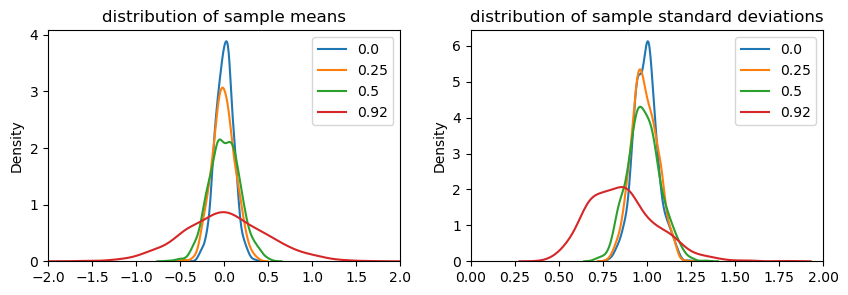

In [5]:
plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
for ia, a in enumerate(auto_vec):
    sns.kdeplot(mu[ia, :], label=str(a), ax=ax)
plt.legend()
plt.xlim(-2.0, 2.0)
plt.title("distribution of sample means")

ax = plt.subplot(1, 2, 2)
for ia, a in enumerate(auto_vec):
    sns.kdeplot(sigma[ia, :], label=str(a), ax=ax)
plt.legend()
plt.xlim(0, 2.0)
plt.title("distribution of sample standard deviations")

plt.show()

#### Part (b)
We see that as the memory in the system increases, the range of possible means also increases - even if the true mean is zero! The range of possible standard deviations also increases, although for 0.92 the standard deviations actually decrease (although the distribution widens). This is because for such a high correlation, the values barely vary across the sample, and so, the variance is actually quite small. Weird!

#### Part (c)

In [6]:
# load the pressure data
filename = "../../../shared/datasets/homework_2_data_P.csv"
dataP = pd.read_csv(filename, sep=",", header=None)

# rain data
filename = "../../../shared/datasets/homework_2_data_R.csv"
dataR = pd.read_csv(filename, sep=",", header=None)

avgP_R = np.mean(dataP.values[np.where(dataR.values > 0)])
print(avgP_R)

847.030625


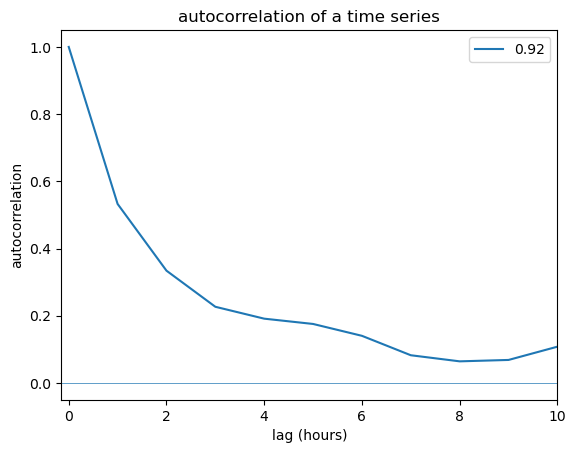

In [7]:
# plot autocorrelation of dataR
plt.figure()
x = dataR.values.flatten()
c = np.correlate(x, x, "same") / (np.var(x) * len(x))
c = c[int(np.size(c) / 2) :]
c = c / c[0]
p = plt.plot(np.arange(0, np.size(c)), c, "-", label=str(auto_vec[ia]))

plt.axhline(y=0, linewidth=0.5)
plt.xlim(-0.15, 10)
plt.xlabel("lag (hours)")
plt.ylabel("autocorrelation")
plt.legend()
plt.title("autocorrelation of a time series")
plt.show()

From the plot above, after about 8 hours my autocorrelation mostly drops to zero. So, every 8th precipitation value appears "independent". I might say 24 hours though just to be safe...

In [8]:
rain_indices = np.where(dataR.values > 0)[0]
# print(rain_indices)
# print(np.diff(rain_indices))

j_blocks = np.where(np.diff(rain_indices) >= 24)[0]
print("number of independent rain events = " + str(len(j_blocks)))

number of independent rain events = 67


So, this suggests I have about 67 independent rain events...not 384!

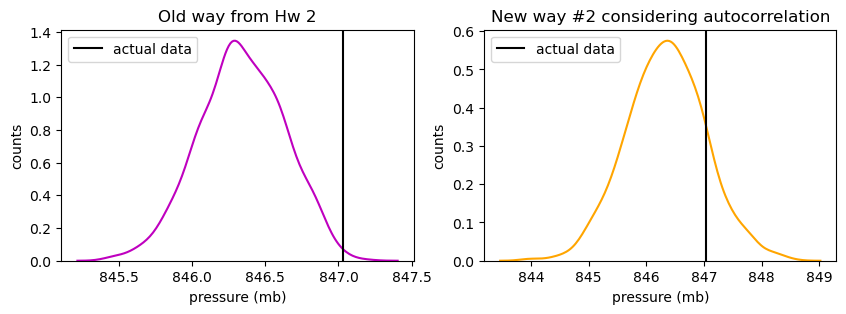

In [9]:
N_old = len(np.where(dataR.values > 0)[0])
N_new = len(j_blocks)
dataVecOld = np.empty((1000,))
dataVec = np.empty((1000,))

for loop in np.arange(0, len(dataVec)):
    # repeating HW2 method
    sample = np.random.choice(dataP.values.flatten(), N_old)
    sampleMean = np.mean(sample)
    dataVecOld[loop] = sampleMean

    # considering autocorrelation when I grab random days
    sample = np.random.choice(dataP.values.flatten(), N_new)
    sampleMean = np.mean(sample)
    dataVec[loop] = sampleMean


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.kdeplot(dataVecOld, color="m")
plt.axvline(x=avgP_R, color="k", label="actual data")
plt.ylabel("counts")
plt.xlabel("pressure (mb)")
plt.legend()
plt.title("Old way from Hw 2")

plt.subplot(1, 2, 2)
sns.kdeplot(dataVec, color="orange")
plt.axvline(x=avgP_R, color="k", label="actual data")
plt.ylabel("counts")
plt.xlabel("pressure (mb)")
plt.legend()
plt.title("New way #2 considering autocorrelation")


plt.show()

Yes! My conclusions change drastically. With this new way the average pressure I got was not odd at all! Yikes! [Memory matters!](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-17-0334.1)

Yet another way to do it would be counting the number of raining "runs" in the data, and then using that as my effective sample size.

In [10]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)


rain_bool = dataR.values.flatten()
rain_bool[rain_bool > 0.0] = 1.0
print(np.unique(rain_bool))

runs = consecutive(rain_bool, stepsize=0)
dur = []
for r in runs:
    if np.unique(r) == 1.0:
        dur.append(len(r))
print("np.sum(dur) = " + str(np.sum(dur)))
print("# of raining runs = " + str(len(dur)))

[0. 1.]
np.sum(dur) = 384
# of raining runs = 149


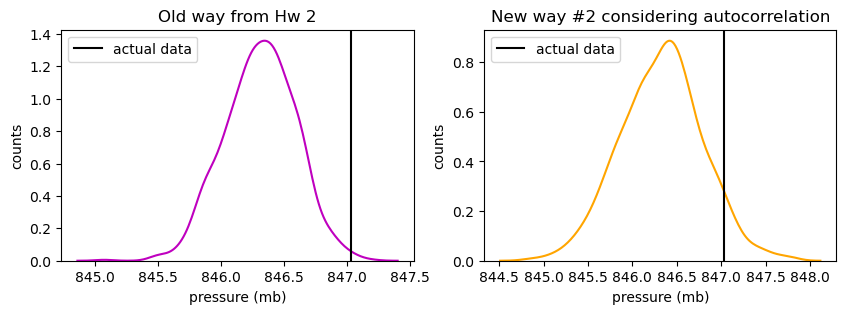

In [11]:
N_old = len(np.where(dataR.values > 0)[0])
N_new = len(dur)
dataVecOld = np.empty((1000,))
dataVec = np.empty((1000,))

for loop in np.arange(0, len(dataVec)):
    # repeating HW2 method
    sample = np.random.choice(dataP.values.flatten(), N_old)
    sampleMean = np.mean(sample)
    dataVecOld[loop] = sampleMean

    # considering autocorrelation when I grab random days
    sample = np.random.choice(dataP.values.flatten(), N_new)
    sampleMean = np.mean(sample)
    dataVec[loop] = sampleMean


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.kdeplot(dataVecOld, color="m")
plt.axvline(x=avgP_R, color="k", label="actual data")
plt.ylabel("counts")
plt.xlabel("pressure (mb)")
plt.legend()
plt.title("Old way from Hw 2")

plt.subplot(1, 2, 2)
sns.kdeplot(dataVec, color="orange")
plt.axvline(x=avgP_R, color="k", label="actual data")
plt.ylabel("counts")
plt.xlabel("pressure (mb)")
plt.legend()
plt.title("New way #2 considering autocorrelation")


plt.show()

And yet another way would be actual block bootstrapping, where I grab the same length of run as actually occurred, but starting at a random sample instead of starting on raining days.

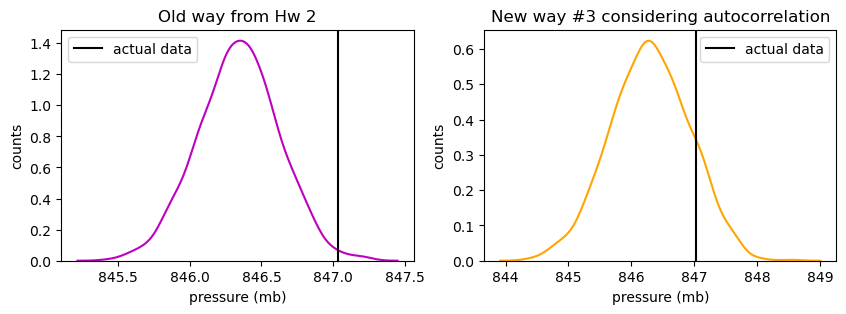

In [12]:
N_old = len(np.where(dataR.values > 0)[0])
N_new = len(dur)
dataVecOld = np.empty((1000,))
dataVec = np.empty((1000,))

for loop in np.arange(0, len(dataVec)):
    # repeating HW2 method
    sample = np.random.choice(dataP.values.flatten(), N_old)
    sampleMean = np.mean(sample)
    dataVecOld[loop] = sampleMean

    # considering autocorrelation when I grab random days
    sample = 0
    count = 0
    for d in dur:
        i = np.random.randint(low=0, high=np.shape(dataP)[0] - d)
        new_values = dataP.values[i : i + d].flatten()
        sample = sample + np.sum(new_values)
        count = count + len(new_values)
    if count != 384:
        print("error - something is wrong")
    sampleMean = sample / count
    dataVec[loop] = sampleMean


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.kdeplot(dataVecOld, color="m")
plt.axvline(x=avgP_R, color="k", label="actual data")
plt.ylabel("counts")
plt.xlabel("pressure (mb)")
plt.legend()
plt.title("Old way from Hw 2")

plt.subplot(1, 2, 2)
sns.kdeplot(dataVec, color="orange")
plt.axvline(x=avgP_R, color="k", label="actual data")
plt.ylabel("counts")
plt.xlabel("pressure (mb)")
plt.legend()
plt.title("New way #3 considering autocorrelation")


plt.show()

## Problem 2 
You are meant to use your own data, but below shows the case of using X = ENSO index and Y = global mean temperature

In [13]:
# load ENSO data
datafile = "../../../shared/datasets/ENSO_CTI_Jan1958Dec2008.csv"
X = pd.read_csv(datafile, sep=",", header=None)
X.head()

,0
0,1.35940
1,1.15900
2,0.86621
3,0.37113
4,0.28050


In [14]:
# load GMT data
datafile = (
    "../../../shared/datasets/GlobalMeanTemperature_monthly_01_1958_to_12_2008.csv"
)
Y = pd.read_csv(datafile, sep=",", header=None)
Y.head()

,0
0,0.253420
1,0.145300
2,-0.023480
3,-0.029557
4,-0.031578


In [15]:
# turn data in np.array
X = np.asarray(X)
Y = np.asarray(Y)

#### Part (a)

In [16]:
# standardize X and Y
Xs = X - np.mean(X)
Ys = Y - np.mean(Y)

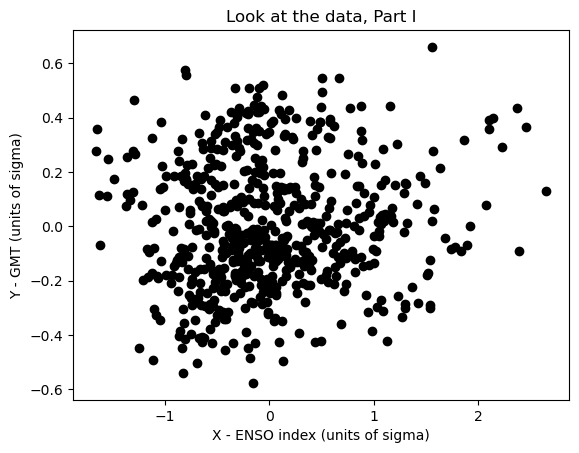

In [17]:
plt.figure()
plt.plot(Xs, Ys, "ok")
plt.xlabel("X - ENSO index (units of sigma)")
plt.ylabel("Y - GMT (units of sigma)")
plt.title("Look at the data, Part I")
plt.show()

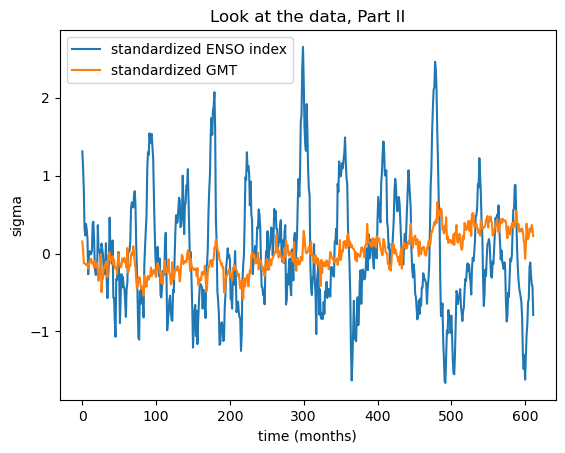

In [18]:
plt.figure()
plt.plot(Xs, "-", label="standardized ENSO index")
plt.plot(Ys, "-", label="standardized GMT")
plt.xlabel("time (months)")
plt.ylabel("sigma")
plt.legend()
plt.title("Look at the data, Part II")
plt.show()

There is a trend in my GMT data! While we know global warming is happening, what we are interested in here is how ENSO may drive global mean temperature on year-to-year timescales, not that ENSO is driving a global trend. Thus, let's first remove the trend in GMT before moving any further. We could also remove an ENSO trend, but I don't really see one, plus, I don't have a lot of scientific evidence to backup why there would be a trend in the ENSO index in the first place. Right -- removing the trend in Y!

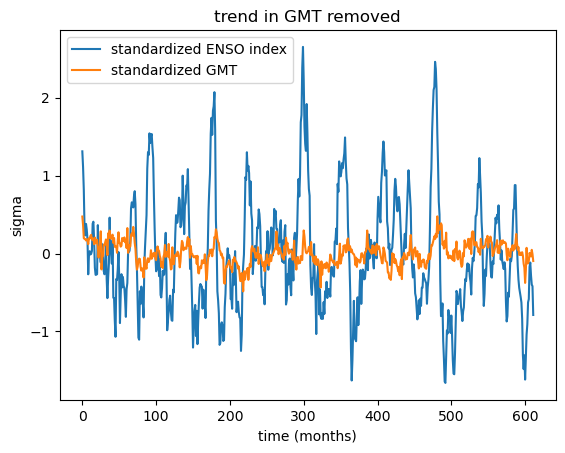

In [19]:
N = np.shape(Y[:, 0])[0]

# compute trend in TIME
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, N), Y[:, 0])

# remove the linear trend in TIME
Y[:, 0] = Y[:, 0] - (np.arange(0, N) * slope + intercept)
Ys = Y - np.mean(Y)

plt.figure()
plt.plot(Xs, "-", label="standardized ENSO index")
plt.plot(Ys, "-", label="standardized GMT")
plt.xlabel("time (months)")
plt.ylabel("sigma")
plt.legend()
plt.title("trend in GMT removed")
plt.show()

#### Part (b)

In [20]:
# correlation
c = np.corrcoef(Xs[:, 0], Y[:, 0])[0, 1]
print(c)

# regression coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(Xs[:, 0], Y[:, 0])
print(slope, r_value)

# fraction of variance explained
fracVar = c**2
print(fracVar)

0.2320375952444931
0.04597700509269567 0.23203759524449313
0.053841445606847206


* The correlation is 0.23 between these two indices. Seems sort of high I guess.
* The slope is 0.05 Kelvin/sigma in the ENSO index. 
* The fraction of variance explained is not huge - about 5%.

#### Part (c)

In [21]:
r, p = stats.pearsonr(Xs[:, 0], Y[:, 0])
print(r, p)

0.23203759524449305 6.321945593275919e-09


Without considering autocorrelation/memory, the p-value is tiny. However, we know that ENSO has memory (as does GMT) and we are not accounting for this thus far. So, instead, let's first look at the memory of the ENSO index.

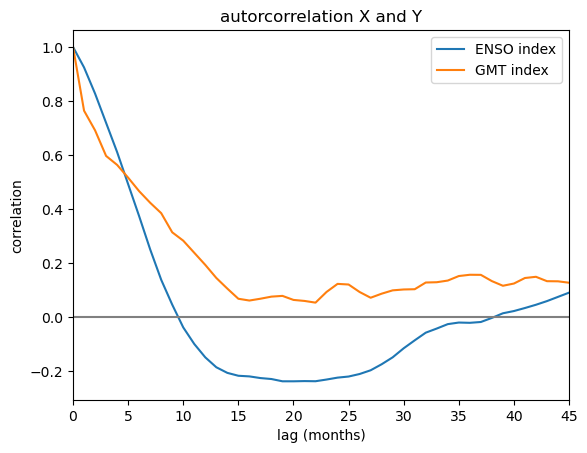

In [22]:
c = np.correlate(Xs[:, 0], Xs[:, 0], "same") / (np.var(X) * np.size(X))
c = c[int(np.size(c) / 2) :]

cy = np.correlate(Ys[:, 0], Ys[:, 0], "same") / (np.var(Y) * np.size(Y))
cy = cy[int(np.size(cy) / 2) :]

plt.figure()
plt.plot(np.arange(0, np.size(c)), c, "-", label="ENSO index")
plt.plot(np.arange(0, np.size(cy)), cy, "-", label="GMT index")
plt.xlim(0, 45)
plt.axhline(y=0, color="gray")
plt.title("autorcorrelation X and Y")
plt.xlabel("lag (months)")
plt.legend()
plt.ylabel("correlation")
plt.show()

This suggests that perhaps it is only once every 6 months or so the ENSO index and GMT can be considered unique (ballpark). With this in mind, instead of having N = 612, we have N = 102. Since N is still quite large we can use the t-statistic.

In [23]:
N = np.shape(X)[0]
Neff = N / 6.0

r, p = stats.pearsonr(Xs[:, 0], Y[:, 0])
t = r * np.sqrt(Neff - 2) / np.sqrt(1 - r**2)
pvalue = 2.0 * (
    1.0 - stats.norm.cdf(t)
)  # need to include both sides, not just one-sided, hence the multiplication by 2.
print(pvalue)

0.017056692891097347


The p-value is still quite low, which bolsters our thinking that ENSO may actually have a strong enough signal to input GMT on year-to-year timescales.

#### Part (d)

In [24]:
il = np.where(Xs < -1.0)[0]
n_low = len(il)
YanomLow = np.mean(Y[il]) - np.mean(Y)

ih = np.where(Xs > 1.0)[0]
n_high = len(ih)
YanomHigh = np.mean(Y[ih]) - np.mean(Y)

print(YanomLow, YanomHigh)

-0.04734203072936694 0.04436021544926236


These are our anomalies, and they make sense. The big question is whether to use N or Neff, and neither seems that great of a choice since the indices upon which we composite are sometimes in a row and other times not. This is where a bootstrap resampling approach could be best. Nevertheless, for now, let's use a t-test and use a very strict definition of N = Neff.

In [25]:
sigma = np.std(Y)

tHigh = (YanomHigh - 0.0) / (sigma / np.sqrt(n_high))
pvalueHigh = 2.0 * (1.0 - stats.norm.cdf(tHigh))

tLow = (YanomLow - 0.0) / (sigma / np.sqrt(n_low))
pvalueLow = 2.0 * (stats.norm.cdf(tLow))

print(tLow, tHigh)
print(pvalueLow, pvalueHigh)

-1.979196841791658 2.45805484814588
0.04779384837304793 0.013969183774761529


The p-values are small (at least less than 0.05). Once again, the composite analysis supports our thinking that there may be a real relationship here. Again, we have physics to back us up too!

#### Part (e)
Correlation analysis focuses on the linear relationship and uses all of the data while the composite analysis focuses on the extremes and only uses the tail ends of the distribution, at least the way that I did it here.